# Predicting Teacher Turnover

__Meaghan Ross__

Flatiron School Capstone

![teacher-turnover](images/teacher-retention-illustration.jpeg)

### Business Understanding

Teacher turnover has been identified as one of the key factors contributing to teacher shortages, which have been growing since 2015. According to the [Learning Policy Institute](https://learningpolicyinstitute.org/product/teacher-turnover-brief), about 8% of teachers leave the profession each year, two-thirds of them for reasons other than retirement and another 8% shift to different schools each year. Additionally, beginning teachers have the highest turnover rates and somewhere between 40-50% of those that go into teaching are gone within five years.

High turnover rates have been found to lower student achievement and are costly for schools. The revolving door of teacher turnover costs school districts upwards of $2.2 billion a year nationally. In 2019, The [Philadelphia Inquirer](https://www.inquirer.com/news/philadephia-district-schools-teacher-turnover-solutions-20190503.html) found that there were 26 schools in the 217 School District of Philadelphia public schools that have lost at least 25 percent of their teachers for four years straight or lost more than one-third in each of the last two school years. Richard Ingersoll, a University of Pennsylvania professor and expert in school staffing, called these findings “appalling.”

The goal of this project is to create a classification model for the School District of Philadelphia that predicts which teachers will leave their current school of employment at the end of a school year. This model will allow district administrators to provide intervention in attempts to retain those teachers who are identified as leaving, or to notify school administrators to prepare earlier to hire quality teachers to fill vacancies. 

The metric of interest for this project is recall. By looking to maximize the recall, the aim is to minimize false negatives where the model predicts that a teacher will stay in their current school when they actually end up leaving. Missing predictions of actual teacher turnover would be costly to the district because they would have to hire and train new teachers unexpectedly. In this circumstance, false positives could also result in monetary cost to provide what could be considered unnecessary intervention, as false positives occur when the model predicts a teacher will leave their school, but they actually stay the following school year. Compared to the costs of false negatives, the costs of false positives could actually end up having a positive effect on long term retention and are not nearly as costly of having to hire and train new teachers.

### Data Understanding

For this project, publicly available data was gathered from the School District of Philadelphia. 

Research on teacher turnover has shown that occupational factors and student demographic factors influence turnover, so both types of features were incorporated to the final data frame. 

The many datasets were:
* [Employee Information](https://www.philasd.org/performance/programsservices/open-data/district-information/#employee_data): This data included the occupational factors for individual teachers including gender, salary, and their title description.
* [School Progress Reports](https://www.philasd.org/performance/programsservices/school-progress-reports/spr-helpful-resources/): This data includes school ratings in the areas of achievement, progress, and climate.
* [Student Enrollment & Demographic Information](https://www.philasd.org/performance/programsservices/open-data/school-information/#school_enrollment): This data includes student demographic factors which includes the rates of economically disadvantaged, ELL (English Language Learners), IEP (Special Education), and ethincity by school.

The final dataset that resulted from merging the occupational factors with student demographic factors contained approximately 8,000 records representing teachers in the School District of Philadelphia from the 2017-2018 school year. Those teachers were identified as either returning to their current placement or having turned over using employee information from the 2018-2019 school year. The preparation of the final dataset can be viewed in the [Data Preparation Notebook](./Data_Prep.ipynb).

### Import Dependencies and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, \
PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,\
plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate

%run -i 'src.py'

Load the data from the [Data Prep](Data_Prep.ipynb) Notebook.

In [2]:
ls data/

2017-2018 Enrollment & Demographics.xlsx
SPR_SY1718_School_Metric_Scores_20190129.xlsx
df_2019.csv
employee_information_April2018.csv
employee_information_April2019.csv


In [3]:
df = pd.read_csv('data/df_2019.csv', index_col=0)

## EDA

In [4]:
pd.set_option('max_columns', None)
df.sample(5)

,LAST_NAME,FIRST_NAME,PAY_RATE,TITLE_DESCRIPTION,HOME_ORGANIZATION,ORGANIZATION_LEVEL,GENDER,School,Zip Code,Turnaround Model,Enrollment,Admissions Type,Overall Score,Overall Tier,Ach Score,Ach Tier,Prog Score,Prog Tier,Clim Score,Clim Tier,Attendance (95%+) Score,Attendance (95%+) Tier,Retention Score,Retention Tier,ISS Score,ISS Tier,OSS Score,OSS Tier,Student Survey Climate Score,Student Survey Climate Tier,Parent Survey Climate Score,Parent Survey Climate Tier,Parent Survey Participation Score,Parent Survey Participation Tier,Teacher Attendance Score,Student Survey Teaching Score,Percent ELL,Percent IEP,Percent Male,Percent Asian,Percent Black/African American,Percent Hispanic,Percent Multi-Race,Percent White,Economically Disadvantaged Rate,NEW_TEACHER,TURNOVER
123,ALSTON,AARIS,48945,"TEACHER,FULL TIME",7290.0,ELEMENTARY SCHOOL,F,Allen M. Stearne School,19124.0,None,517.0,Neighborhood,26,WATCH,0,INTERVENE,62,REINFORCE,9.0,INTERVENE,32.0,INTERVENE,73.0,INTERVENE,100.0,MODEL,83.0,INTERVENE,0,INTERVENE,69.0,REINFORCE,10.0,INTERVENE,43,0,0.061776,0.187259,0.478764,0.009653,0.548263,0.332046,0.067568,0.034749,1.000000,1,1
7888,WESCOTT,STACEY,76461,"TEACHER,SPEC EDUCATION",7120.0,HIGH SCHOOL,F,Samuel Fels High School,19124.0,None,962.0,Neighborhood,18,INTERVENE,1,INTERVENE,21,INTERVENE,42.0,WATCH,32.0,INTERVENE,80.0,REINFORCE,100.0,MODEL,88.0,REINFORCE,50,REINFORCE,72.0,REINFORCE,10.0,INTERVENE,63,41,0.181535,0.231328,0.535270,0.065353,0.607884,0.232365,0.051867,0.041494,1.000000,0,0
3161,HAYES-WILKERSON,OPHELIA,83382,"TEACHER,FULL TIME",7310.0,ELEMENTARY SCHOOL,F,Feltonville Intermediate School,19120.0,None,761.0,Neighborhood,61,REINFORCE,7,INTERVENE,86,MODEL,79.0,MODEL,52.0,MODEL,89.0,MODEL,100.0,MODEL,96.0,MODEL,57,REINFORCE,82.0,MODEL,10.0,INTERVENE,55,68,0.206307,0.111695,0.509855,0.044678,0.231275,0.609724,0.084100,0.028909,1.000000,0,0
4463,LOPEZ,MELISSA,76461,"TEACHER,FULL TIME",7470.0,ELEMENTARY SCHOOL,F,Bridesburg School,19137.0,None,814.0,Neighborhood,58,REINFORCE,35,WATCH,75,MODEL,59.0,REINFORCE,45.0,WATCH,92.0,MODEL,100.0,MODEL,97.0,MODEL,0,INTERVENE,89.0,MODEL,10.0,INTERVENE,59,0,0.014706,0.139706,0.542892,0.004902,0.012255,0.064951,0.067402,0.846814,0.962745,0,0
928,BURKE,SHARON,67789,"TEACHER,FULL TIME",2160.0,HIGH SCHOOL,F,Furness High School,19148.0,None,669.0,Neighborhood,26,WATCH,3,INTERVENE,30,WATCH,61.0,REINFORCE,38.0,WATCH,86.0,MODEL,100.0,MODEL,87.0,REINFORCE,51,REINFORCE,74.0,REINFORCE,17.0,INTERVENE,72,48,0.459138,0.142645,0.591382,0.442793,0.185736,0.239227,0.026746,0.105498,1.000000,0,1


Identify teacher profile for presentation.

In [5]:
df.loc[8066]

LAST_NAME                                             WOMACK
FIRST_NAME                                               MAY
PAY_RATE                                               47278
TITLE_DESCRIPTION                          TEACHER,FULL TIME
HOME_ORGANIZATION                                       5160
ORGANIZATION_LEVEL                               HIGH SCHOOL
GENDER                                                     F
School                               Penn Treaty High School
Zip Code                                               19125
Turnaround Model                                        None
Enrollment                                               342
Admissions Type                                 Neighborhood
Overall Score                                             36
Overall Tier                                           WATCH
Ach Score                                                  5
Ach Tier                                           INTERVENE
Prog Score              

There are some columns that are currently listed as objects that should be numerical so to do proper EDA we should transform those in order to explore relationships.

In [6]:
df_eda = df.copy()

In [7]:
obj_to_num = ['Student Survey Climate Score', 'Student Survey Teaching Score', 
                  'Overall Score', 'Ach Score', 'Prog Score']

In [8]:
for col in obj_to_num:
    df_eda.loc[(df_eda[col] == 'Not Applicable'), col] = 0
    df_eda.loc[(df_eda[col] == 'Insufficient Data'), col] = 0

In [9]:
for col in obj_to_num:
    df_eda[col] = df_eda[col].astype('float64')
for col in [df_eda.select_dtypes('int64').columns]:
    df_eda[col] = df_eda[col].astype('float64')

__Cleaning up data for deployment__

In [10]:
df_eda = df_eda.rename(columns={'PAY_RATE': 'Salary',
                                'NEW_TEACHER': 'New Teacher',
                                'ORGANIZATION_LEVEL': 'School Level',
                                'GENDER': 'Gender',
                                'TITLE_DESCRIPTION': 'Title Description',
                                'Ach Tier': 'Achievement Tier',
                                'Prog Tier': 'Progress Tier',
                                'Clim Tier': 'Climate Tier'})

In [11]:
def teaching_experience(row):
    if row['New Teacher'] == 1 :
        return '0-3 Years'
    if row['New Teacher'] == 0 :
        return '4+ Years'

In [12]:
df_eda['Teaching Experience'] = df_eda.apply(lambda row: teaching_experience(row), axis=1)

In [13]:
def turnover_words(row):
    if row['TURNOVER'] == 1 :
        return 'Turnover'
    if row['TURNOVER'] == 0 :
        return 'Retention'

In [14]:
df_eda['Status'] = df_eda.apply (lambda row: turnover_words(row), axis=1)

In [15]:
df_eda.to_csv('data/df_eda.csv')

In [16]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7927 entries, 0 to 8251
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   LAST_NAME                          7927 non-null   object 
 1   FIRST_NAME                         7927 non-null   object 
 2   Salary                             7927 non-null   float64
 3   Title Description                  7927 non-null   object 
 4   HOME_ORGANIZATION                  7927 non-null   float64
 5   School Level                       7927 non-null   object 
 6   Gender                             7927 non-null   object 
 7   School                             7927 non-null   object 
 8   Zip Code                           7927 non-null   float64
 9   Turnaround Model                   7927 non-null   object 
 10  Enrollment                         7927 non-null   float64
 11  Admissions Type                    7927 non-null   objec

In [17]:
df_eda.describe()

,Salary,HOME_ORGANIZATION,Zip Code,Enrollment,Overall Score,Ach Score,Prog Score,Clim Score,Attendance (95%+) Score,Retention Score,ISS Score,OSS Score,Student Survey Climate Score,Parent Survey Climate Score,Parent Survey Participation Score,Teacher Attendance Score,Student Survey Teaching Score,Percent ELL,Percent IEP,Percent Male,Percent Asian,Percent Black/African American,Percent Hispanic,Percent Multi-Race,Percent White,Economically Disadvantaged Rate,New Teacher,TURNOVER
count,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000,7927.000000
mean,69445.358017,5449.568563,19132.066229,745.185064,40.436104,19.154535,51.069888,50.104958,45.441024,83.893150,99.234515,92.015895,49.018418,50.585215,16.800934,62.391825,48.745175,0.107116,0.150743,0.519010,0.077719,0.506891,0.205425,0.069506,0.137435,0.935210,0.171439,0.189353
std,13310.902174,2366.607163,13.192849,543.100051,20.881016,21.511611,27.926988,26.560342,17.048269,8.177368,2.219504,7.044074,17.597439,39.161325,14.513308,11.915968,19.212838,0.102088,0.076513,0.063495,0.104955,0.299275,0.205538,0.034410,0.169208,0.139592,0.376916,0.391813
min,32561.000000,1010.000000,19103.000000,115.000000,0.000000,0.000000,0.000000,3.000000,14.000000,54.000000,84.000000,63.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.006281,0.001007,0.000000,0.012255,0.005405,0.003597,0.000000,0.217801,0.000000,0.000000
25%,59532.000000,4020.000000,19121.000000,457.000000,26.000000,3.000000,25.000000,28.000000,33.000000,79.000000,100.000000,88.000000,48.000000,0.000000,7.000000,55.000000,43.000000,0.013514,0.095436,0.503008,0.004438,0.238693,0.037879,0.044597,0.018405,0.962745,0.000000,0.000000
50%,70564.000000,5700.000000,19134.000000,579.000000,38.000000,12.000000,52.000000,49.000000,43.000000,84.000000,100.000000,94.000000,53.000000,74.000000,12.000000,63.000000,53.000000,0.081633,0.138158,0.523126,0.033113,0.427262,0.140316,0.066548,0.060000,1.000000,0.000000,0.000000
75%,76461.000000,7430.000000,19143.000000,858.000000,54.000000,29.000000,79.000000,71.000000,55.000000,89.000000,100.000000,98.000000,58.000000,83.000000,23.000000,71.000000,61.000000,0.182174,0.196296,0.546778,0.113314,0.838590,0.287762,0.091820,0.189707,1.000000,0.000000,0.000000
max,90051.000000,8770.000000,19154.000000,3363.000000,95.000000,96.000000,98.000000,97.000000,95.000000,100.000000,100.000000,100.000000,80.000000,99.000000,83.000000,96.000000,85.000000,0.543524,0.375587,0.700000,0.504814,0.970588,0.809249,0.215434,0.846814,1.000000,1.000000,1.000000


Set colors for visualizations.

In [18]:
color=["lightsteelblue", "orange"]

In [19]:
color_patches = [Patch(facecolor=color[0], label="retention"), 
                 Patch(facecolor=color[1], label="turnover")]

### Target Variable

__What is the distribution of teacher turnover following the 2017-2018 school year?__

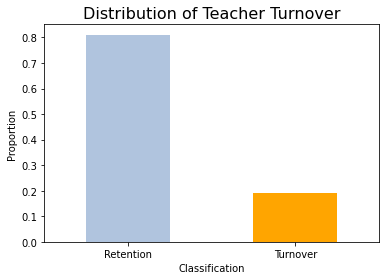

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))

df_eda['TURNOVER'].value_counts(normalize=True).plot(kind='bar', 
                                                     color=color, 
                                                     ax=ax)

ax.set_xlabel("Classification")
ax.set_xticklabels(['Retention', 'Turnover'], rotation=0)
ax.set_ylabel("Proportion")
ax.set_title("Distribution of Teacher Turnover", fontsize=16)
fig.savefig('images/Target.png');

Approximately 20% of the teachers in the School District of Philadelphia did not return to their position following the 2017-2018 school year. This shows that there is a class imbalance to take into account for modeling as a majority of teachers do stay at their current school.

### Occupational Factors

__What is the relationship between teaching experience and turnover?__

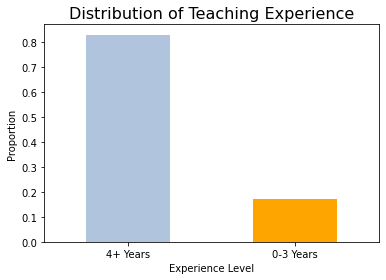

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))

df_eda['New Teacher'].value_counts(normalize=True).plot(kind='bar', 
                                                        color=color, 
                                                        ax=ax)

ax.set_xlabel("Experience Level")
ax.set_xticklabels(['4+ Years', '0-3 Years'], rotation=0)
ax.set_ylabel("Proportion")
ax.set_title("Distribution of Teaching Experience", fontsize=16);

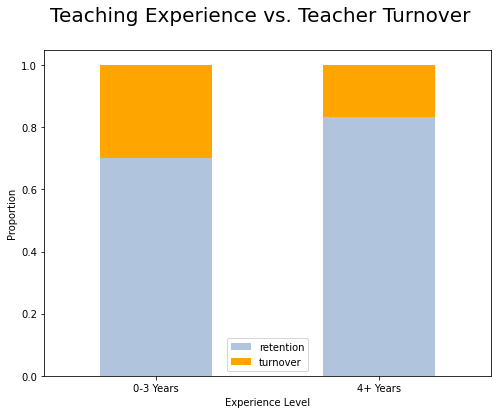

In [22]:
counts_df = df_eda.groupby(["New Teacher", "TURNOVER"])["HOME_ORGANIZATION"].count().unstack()
turnover_percents_df = counts_df.T.div(counts_df.T.sum()).T.reindex([1, 0])
fig, ax = plt.subplots(figsize=(8, 6))

turnover_percents_df.plot(kind="bar", stacked=True, color=color, ax=ax)

ax.set_xlabel("Experience Level")
ax.set_xticklabels(['0-3 Years', 
                    '4+ Years'], rotation=0)
ax.set_ylabel("Proportion")
ax.legend(handles=color_patches)

fig.suptitle("Teaching Experience vs. Teacher Turnover", fontsize=20)
fig.savefig('images/New_teacher.png');

In [23]:
turnover_percents_df

TURNOVER,0.0,1.0
New Teacher,,
1,0.699779,0.300221
0,0.833587,0.166413


New teachers make up less than 20% of the teacher force in Philadelphia. New teachers are those whose salaries indicate they have 3 years of experience or less. Interestingly, the rate of turnover for new teachers is nearly double that of teachers with more experience at 30%.

__What is the relationship between type of teacher (General Education vs Special Education) and teacher turnover?__

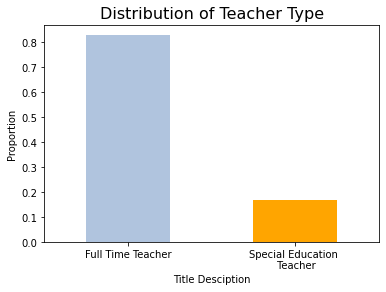

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

df_eda['Title Description'].value_counts(normalize=True).plot(kind='bar', 
                                                              color=color, 
                                                              ax=ax)

ax.set_xlabel("Title Desciption")
ax.set_xticklabels(['Full Time Teacher', 'Special Education \n Teacher'], rotation=0)
ax.set_ylabel("Proportion")
ax.set_title("Distribution of Teacher Type", fontsize=16);

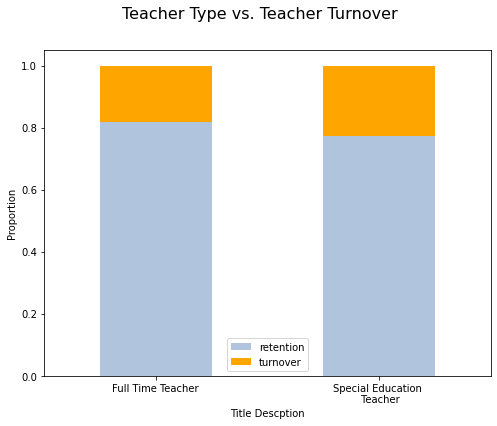

In [25]:
counts1_df = df_eda.groupby(["Title Description", "TURNOVER"])["HOME_ORGANIZATION"].count().unstack()
turnover_percents_bytype_df = counts1_df.T.div(counts1_df.T.sum()).T
fig, ax = plt.subplots(figsize=(8, 6))

turnover_percents_bytype_df.plot(kind="bar", stacked=True, color=color, ax=ax)

ax.set_xlabel("Title Descption")
ax.set_xticklabels(['Full Time Teacher', 
                    'Special Education \n Teacher'], rotation=0)
ax.set_ylabel("Proportion")
ax.legend(handles=color_patches)

fig.suptitle("Teacher Type vs. Teacher Turnover", fontsize=16);

Special Education teachers make up a smaller proportion of the teacher workforce in Philadelphia. Special Education teachers have a slightly higher rate of turnover than full time teachers, so this feature may not be as important for modeling.

__What is the relationship between Gender and Teacher Turnover?__

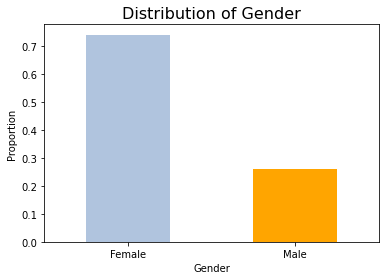

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))

df_eda['Gender'].value_counts(normalize=True).plot(kind='bar', 
                                                   color=color, ax=ax)

ax.set_xlabel("Gender")
ax.set_xticklabels(['Female', 'Male'], rotation=0)
ax.set_ylabel("Proportion")
ax.set_title("Distribution of Gender", fontsize=16);

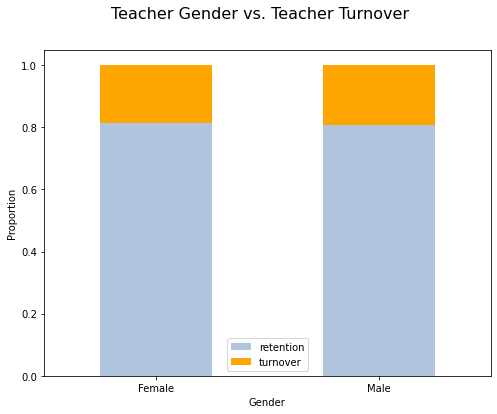

In [27]:
counts2_df = df_eda.groupby(["Gender", "TURNOVER"])["HOME_ORGANIZATION"].count().unstack()
turnover_percents_bygender_df = counts2_df.T.div(counts2_df.T.sum()).T
fig, ax = plt.subplots(figsize=(8, 6))

turnover_percents_bygender_df.plot(kind="bar", stacked=True, color=color, ax=ax)

ax.set_xlabel("Gender")
ax.set_xticklabels(['Female', 'Male'], rotation=0)
ax.set_ylabel("Proportion")
ax.legend(handles=color_patches)

fig.suptitle("Teacher Gender vs. Teacher Turnover", fontsize=16);

Teachers who identify as female make up a majority of the workforce, however gender does not seem to play a role in turnover rates as males and females have similar rates of turnover.

__What is the relationship between salary and teacher turnover?__

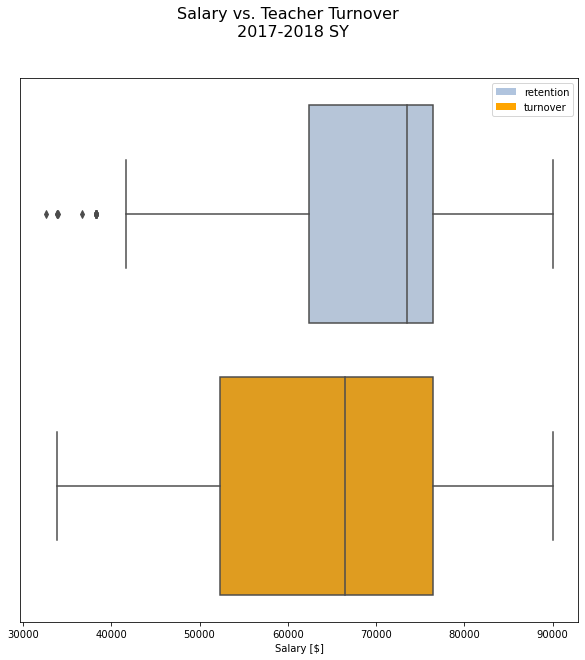

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x="Salary", 
            y="TURNOVER", 
            data=df_eda, 
            orient="h", 
            palette={1:color[1], 0:color[0]}, 
            ax=ax)
ax.get_yaxis().set_visible(False)
fig.suptitle("Salary vs. Teacher Turnover \n 2017-2018 SY", fontsize=16)
ax.legend(handles=color_patches)
ax.set_xlabel('Salary [$]');

Teachers who were not retained at their school following the 2017-2018 school year tended to have lower salaries than those teachers who were retained. This goes along with the information about new teacher (who have lower salaries) leaving at higher rates.

### School Demographic Factors

__What is the distribution of economically disadvantaged students in relation to teacher turnover?__

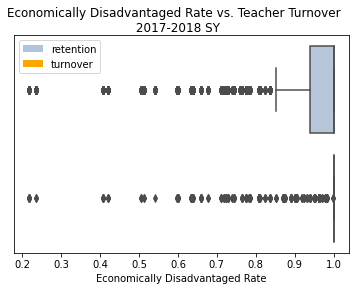

In [29]:
fig, ax = plt.subplots()
sns.boxplot(x="Economically Disadvantaged Rate", 
            y="TURNOVER", data=df_eda, orient="h", 
            palette={1:color[1], 0:color[0]}, ax=ax)
ax.get_yaxis().set_visible(False)
fig.suptitle("Economically Disadvantaged Rate vs. Teacher Turnover \n 2017-2018 SY")
ax.legend(handles=color_patches)
ax.set_xlabel('Economically Disadvantaged Rate');

Schools with higher rates of economically disadvantaged students are associated with higher rates of teacher turnover.

__What is the relationship between School Climate Scores and Teacher Turnover?__

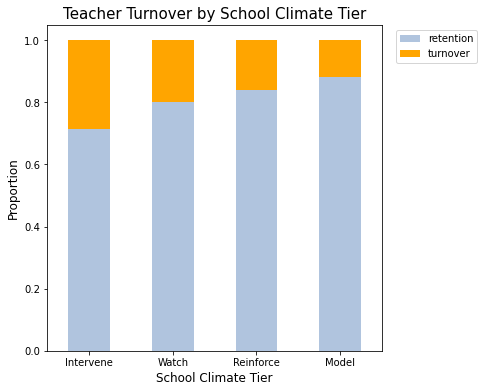

In [30]:
climate_turnover = pd.crosstab(df_eda['Climate Tier'], 
                               df_eda['TURNOVER'], 
                               normalize='index')

climate_turnover_copy = climate_turnover.T.copy()
climate_turnover_copy = climate_turnover_copy[['INTERVENE', 'WATCH', 'REINFORCE', 'MODEL']]
climate_turnover_copy = climate_turnover_copy.T
    
fig, ax = plt.subplots(figsize=(6, 6))
climate_turnover_copy.plot.bar(ax=ax, stacked=True, color=color)
plt.title('Teacher Turnover by School Climate Tier', size=15)
plt.ylabel('Proportion', size=12)
plt.xticks(np.arange(4), ['Intervene', 'Watch', 'Reinforce', 'Model'], rotation=0)
plt.xlabel('School Climate Tier', size=12)
ax.legend(handles=color_patches, bbox_to_anchor=(1.3, 1))
fig.savefig('images/Climate.png');

The Climate domain measures student engagement and school climate, focusing on student attendance, student retention, and in- and out-of-school suspensions. A school’s progress at the domain level is categorized into four performance tiers based on the percentage of possible points earned. Schools with low climate scores and fall into the Intervene Tier have higher rates of teacher turnover than those schools with higher climate scores.

__What is the relationship between Grade Level and Teacher Turnover?__

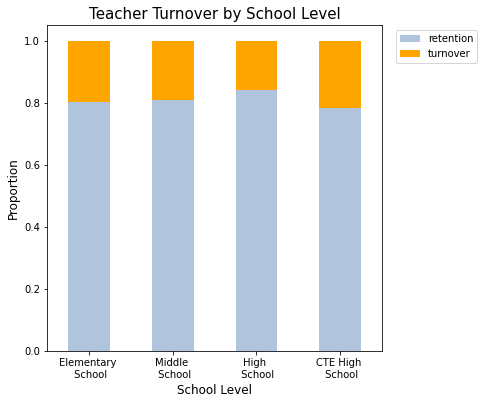

In [31]:
grade_turnover = pd.crosstab(df_eda['School Level'], 
                             df_eda['TURNOVER'], 
                             normalize='index')

grade_turnover_copy = grade_turnover.T.copy()
grade_turnover_copy = grade_turnover_copy[['ELEMENTARY SCHOOL', 
                                           'MIDDLE SCHOOL', 
                                           'HIGH SCHOOL', 
                                           'CAREER AND TECHNICAL HIGH SCHL']]
grade_turnover_copy = grade_turnover_copy.T
    
fig, ax = plt.subplots(figsize=(6, 6))
grade_turnover_copy.plot.bar(ax=ax, stacked=True, color=color)
plt.title('Teacher Turnover by School Level', size=15)
plt.ylabel('Proportion', size=12)
plt.xticks(np.arange(4), ['Elementary \n School', 
                          'Middle \n School', 
                          'High \n School', 
                          'CTE High \n School'], rotation=0)
plt.xlabel('School Level', size=12)
ax.legend(handles=color_patches, bbox_to_anchor=(1.3, 1));

In the School District of Philadelphia, it appears as though High Schools have the lower rates of teacher turnover compared to the other school levels. Interestingly, Career and Technical Education (CTE) High Schools see more teacher turnover than generic high schools. 

From the above EDA it seems like there is a combination of both occupational factors and school demographic factors that contribute to teacher turnover in Philadelpia public schools.

__Additional Visualizations__
In addition to the static visualizations shown above, I also built interactive data visualizations application. It is live on heroku, and you can visit it at this [site](https://exploring-teacher-turnover.herokuapp.com/).



__Continued EDA__

Let's look at the correlations between the numerical features. 

In [32]:
df_eda.corr()

,Salary,HOME_ORGANIZATION,Zip Code,Enrollment,Overall Score,Ach Score,Prog Score,Clim Score,Attendance (95%+) Score,Retention Score,ISS Score,OSS Score,Student Survey Climate Score,Parent Survey Climate Score,Parent Survey Participation Score,Teacher Attendance Score,Student Survey Teaching Score,Percent ELL,Percent IEP,Percent Male,Percent Asian,Percent Black/African American,Percent Hispanic,Percent Multi-Race,Percent White,Economically Disadvantaged Rate,New Teacher,TURNOVER
Salary,1.000000,0.038187,-0.006289,0.084483,0.081015,0.114272,-0.001125,0.124878,0.101647,0.100311,0.023937,0.094068,0.014391,0.030273,-0.017216,0.052436,-0.007280,0.056485,-0.049168,-0.028847,0.115173,-0.105985,-0.018540,0.072683,0.124008,-0.088749,-0.716830,-0.128383
HOME_ORGANIZATION,0.038187,1.000000,-0.173860,0.420716,0.087136,0.032721,0.032713,0.161885,0.042418,0.180387,-0.048261,0.164868,-0.067783,-0.046431,-0.055446,0.005062,-0.031576,0.192007,-0.134362,0.047961,0.022180,-0.379480,0.271753,0.279922,0.269318,0.003295,-0.021044,-0.040983
Zip Code,-0.006289,-0.173860,1.000000,-0.170351,-0.076863,-0.078634,-0.029728,-0.123098,-0.033053,-0.118810,0.063562,0.043937,-0.002077,-0.080520,-0.076155,-0.082204,0.007417,0.048242,-0.004095,-0.130155,0.019649,0.059872,-0.019510,-0.058822,-0.082395,0.178683,-0.003045,0.012072
Enrollment,0.084483,0.420716,-0.170351,1.000000,0.136520,0.188791,0.055080,0.154257,0.089632,0.188510,-0.193487,0.054606,-0.357273,-0.158786,-0.197453,0.017680,-0.345283,0.304387,-0.258881,0.033960,0.448074,-0.368478,0.129420,0.084677,0.198777,-0.112231,-0.066778,-0.074059
Overall Score,0.081015,0.087136,-0.076863,0.136520,1.000000,0.842815,0.794141,0.770077,0.810346,0.693493,0.071990,0.617476,0.367333,0.313406,0.232348,0.356930,0.334956,0.122193,-0.571032,-0.355370,0.562558,-0.398046,-0.158467,0.389763,0.465141,-0.581319,-0.071667,-0.113308
Ach Score,0.114272,0.032721,-0.078634,0.188791,0.842815,1.000000,0.434941,0.733895,0.794655,0.657069,0.028216,0.526810,0.307139,0.255978,0.124734,0.408250,0.235522,-0.066186,-0.484609,-0.326481,0.546492,-0.376198,-0.278603,0.354665,0.591105,-0.777393,-0.093956,-0.115066
Prog Score,-0.001125,0.032713,-0.029728,0.055080,0.794141,0.434941,1.000000,0.299743,0.403191,0.279872,0.025989,0.345737,0.235458,0.260671,0.226941,0.102906,0.290543,0.122182,-0.449542,-0.229285,0.336866,-0.181349,-0.078634,0.245067,0.152903,-0.206669,-0.001738,-0.039779
Clim Score,0.124878,0.161885,-0.123098,0.154257,0.770077,0.733895,0.299743,1.000000,0.884434,0.889190,0.123755,0.685835,0.309986,0.248483,0.192925,0.439631,0.199645,0.239348,-0.469853,-0.337816,0.565987,-0.488072,-0.046860,0.360949,0.495340,-0.576475,-0.112942,-0.147260
Attendance (95%+) Score,0.101647,0.042418,-0.033053,0.089632,0.810346,0.794655,0.403191,0.884434,1.000000,0.755330,0.120543,0.644979,0.302389,0.203678,0.119316,0.367596,0.213480,0.075180,-0.519831,-0.343937,0.558159,-0.315412,-0.216932,0.351204,0.402087,-0.623439,-0.094704,-0.111212
Retention Score,0.100311,0.180387,-0.118810,0.188510,0.693493,0.657069,0.279872,0.889190,0.755330,1.000000,0.034136,0.583733,0.233823,0.149625,0.124893,0.483844,0.124003,0.176674,-0.414310,-0.334934,0.469235,-0.513534,0.054861,0.405245,0.467632,-0.538183,-0.094468,-0.146313


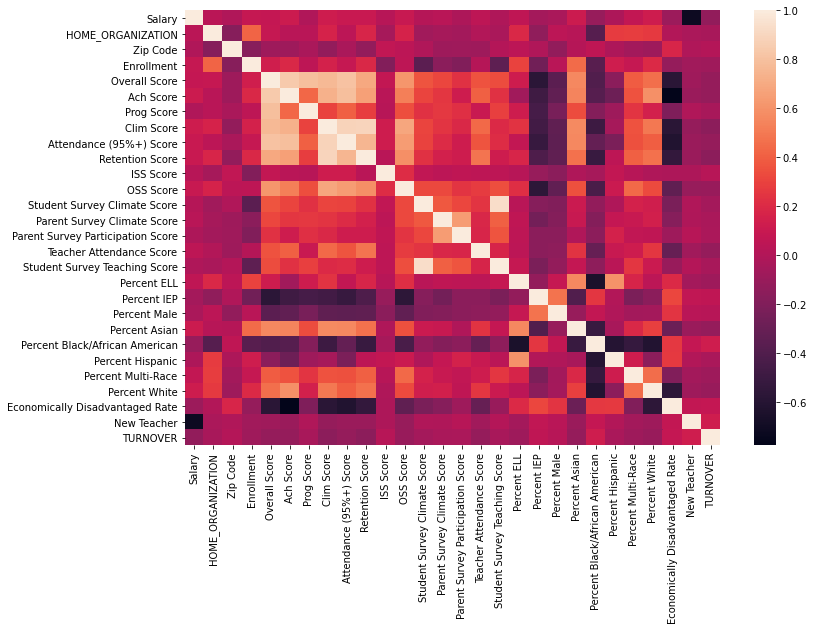

In [33]:
plt.figure(figsize = (12,8))

ax = sns.heatmap(df_eda.corr());

Some featues are more negatively correlated with each other, such as the Econmically Disadvantaged Rate, Percent Black, and Percent IEP (students in special education) with many of the ratings from the School Progress Reports.

### Preprocessing

In order to begin the modeling process, there are a few more columns to drop. Teachers' names will not be useful for modeling. Additionally, the 'Tier' levels are binned versions of the scores that will be in the model so they would be redundent and unnecessary.

In [34]:
drop_modeling = ['LAST_NAME', 'FIRST_NAME', 'HOME_ORGANIZATION', 'School', 'Overall Tier',
                 'Ach Tier', 'Prog Tier', 'Clim Tier', 'Attendance (95%+) Tier', 
                 'Retention Tier', 'ISS Tier', 'OSS Tier', 'Student Survey Climate Tier',
                 'Parent Survey Climate Tier', 'Parent Survey Participation Tier', 'TURNOVER']

In [35]:
X = df.drop(drop_modeling, axis=1)
y = df['TURNOVER']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [36]:
X_train.shape

(5945, 31)

In preprocessing, some columns will need to be modified using a cleaning pipeline. There are some columns that should be numerical and use customs functions in the function transformer. Then, categorical columns need to be converted to numerical data before modeling using OneHotEncoder. This will establish an array of all numerical predictors to be used for modeling.

In [37]:
obj_to_num = ['Student Survey Climate Score', 'Student Survey Teaching Score', 
              'Overall Score', 'Ach Score', 'Prog Score']

cat_columns = ['TITLE_DESCRIPTION', 'ORGANIZATION_LEVEL', 'GENDER', 
               'Turnaround Model', 'Admissions Type', 'Zip Code']

# OneHotEncode the columns as part of cleaning
# to avoid needing to separate numerical and categorical
# columns later
ohe_col_trans = ColumnTransformer(transformers=
                                  [('ohe', OneHotEncoder(drop='first', sparse=False), 
                                    cat_columns)],
                                  remainder='passthrough')

# Apply all our cleaning functions, then finish with ohe
cleaning_pipeline = Pipeline(steps=[
    ('na_trans', FunctionTransformer(na_transformer)),
    ('float', FunctionTransformer(to_float_transformer)),
    ('ohe_trans', ohe_col_trans)
])

In [38]:
X_train_clean = cleaning_pipeline.fit_transform(X_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/meaghanross/Documents/Flatiron/Capstone/Predicting_Teacher_Turnover/src.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('float64')
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [39]:
ohe_feature_names = cleaning_pipeline.steps[-1][1].get_feature_names()

In [40]:
len(X_train.columns)

31

In [41]:
len(ohe_feature_names)

77

After cleaning and One Hot Encoding the categorical columns, the X_train data frame expands from 31 original features to 77 features.

### Modeling

Many models were created for this project. The `DummyClassifier` was used as baseline model. In order to improve on that baseline, we designed `LinearSVD`, `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier`, and `XGBoost` models. 

Two methods were employed to mitigate the class imbalance:
* Passing in class weights as balanced
* Implementing SMOTE

For each model we will build a pipeline using `StandardScaler` and the model of choice. Then we will evaluate the model by running the pipeline through the custom print_cv_scores function and then gather metrics for model efficacy.

Through the model iteration process we are seeking to maximize the recall score by minimizing the number of false negatives, meaning teachers who were predicted to stay and actually end up leaving. By focusing on recall, we are trying to reduce the chances of the model missing a teacher who actually leaves their school the following year.

#### Dummy Classifier

In [42]:
dummy_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('dc', DummyClassifier(strategy='most_frequent'))
])

In [43]:
print_cv_scores(dummy_pipe, X_train_clean, y_train)

[0.81055509 0.81055509 0.81055509 0.81055509 0.81076535]
Training Accuracy 0.8105971404541631
##############
[0.81076535 0.81076535 0.81076535 0.81076535 0.80992431]
Cross_Val Accuracy 0.8105971404541631
##############
Training Recall: 0.0
Cross_Val Recall: 0.0


The Dummy Classifier with strategy set to most frequent scores 0% for the recall and it's accuracy is about the same as the proportion of the target variable.

In [44]:
dummy_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('dc', DummyClassifier(strategy='stratified'))
])
dummy_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('dc', DummyClassifier(strategy='stratified'))])

In [45]:
print_cv_scores(dummy_pipe, X_train_clean, y_train)

[0.70100925 0.69764508 0.69575273 0.69386039 0.70647603]
Training Accuracy 0.6989486963835155
##############
[0.70479394 0.70731707 0.69638352 0.69974769 0.70311186]
Cross_Val Accuracy 0.7022708158116064
##############
Training Recall: 0.19116265877420152
Cross_Val Recall: 0.1873982300884956


In [46]:
dc_acc = 0.6952060555088309 * 100
dc_rec = 0.17937856440511307 * 100

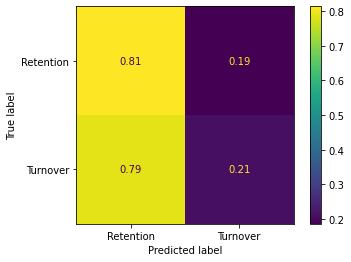

In [47]:
plot_confusion_matrix(dummy_pipe, 
                      X_train_clean, 
                      y_train, 
                      normalize = 'true',
                      display_labels= ['Retention', 'Turnover']);

The Dummy Classifier is having a difficult time predicting the actual turnover and sets a baseline score of 18% to improve upon for the recall score.

#### Linear Support Vector Classification

In [48]:
svc_pipe = Pipeline(steps=[('ss', StandardScaler()),
                           ('svc', LinearSVC(class_weight='balanced',
                                             max_iter =1e5,
                                             random_state=42))
                          ])

svc_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('svc',
                 LinearSVC(class_weight='balanced', max_iter=100000.0,
                           random_state=42))])

In [49]:
print_cv_scores(svc_pipe, X_train_clean, y_train)

[0.64129521 0.62888982 0.64129521 0.62867956 0.62888982]
Training Accuracy 0.6338099243061396
##############
[0.61396131 0.61396131 0.60807401 0.59714045 0.61648444]
Cross_Val Accuracy 0.6099243061396131
##############
Training Recall: 0.6314403748920951
Cross_Val Recall: 0.5710285152409046


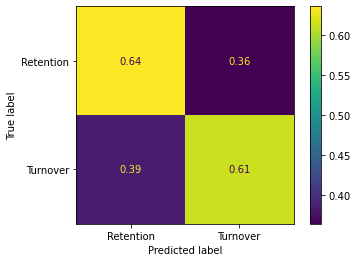

In [50]:
plot_confusion_matrix(svc_pipe, 
                      X_train_clean, 
                      y_train, 
                      normalize = 'true',
                      display_labels= ['Retention', 'Turnover']);

In [51]:
# svc_grid_pipe = Pipeline(steps=[('ss', StandardScaler()),
#                                 ('svc', LinearSVC(class_weight='balanced',
#                                                   max_iter =1e5,
#                                                   random_state=42))
#                                ])

# svc_grid = {'svc__tol': [1e-5,1e-4,1e-3],
#             'svc__C' : [1e-3,1e-1, 1, 100]}

In [52]:
# svc_gridsearch = GridSearchCV(svc_grid_pipe, 
#                               svc_grid, 
#                               return_train_score=True, 
#                               scoring='recall')

# svc_gridsearch.fit(X_train_clean, y_train)

In [53]:
# svc_gridsearch.best_params_

To reduce runtime, the gridsearch for the best parameters for the `LinearSVC` model was commented out, but the results are used in `svc_pipe1`

In [54]:
svc_pipe1 = Pipeline(steps=[('ss', StandardScaler()),
                            ('svc', LinearSVC(class_weight='balanced',
                                              C=0.001,
                                              tol= 1e-05,
                                              max_iter =1e05,
                                              random_state=42))
                           ])
svc_pipe1.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.001, class_weight='balanced', max_iter=100000.0,
                           random_state=42, tol=1e-05))])

In [55]:
print_cv_scores(svc_pipe1, X_train_clean, y_train)

[0.63225399 0.62237174 0.63751051 0.62720774 0.627418  ]
Training Accuracy 0.6293523969722455
##############
[0.60723297 0.61984861 0.61143818 0.60134567 0.6097561 ]
Cross_Val Accuracy 0.6099243061396131
##############
Training Recall: 0.6232260451350351
Cross_Val Recall: 0.5816991150442478


In [56]:
svc_acc = 0.6099243061396131 * 100
svc_rec = 0.5816991150442478 * 100

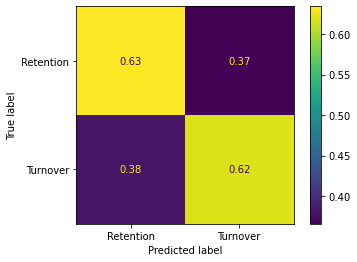

In [57]:
plot_confusion_matrix(svc_pipe1, X_train_clean, y_train, normalize = 'true',
                      display_labels= ['Retention', 'Turnover']);

The Linear Support Vector Classification greatly improves on the recall score of the Dummy Classifier. A con to this model is the computation time for training.

#### Logistic Regression

Let's perform a logistic regression with default hyperparameters.

In [58]:
lr_pipe = Pipeline(steps=[('ss', StandardScaler()),
                          ('lr', LogisticRegression(max_iter=1e4,
                                                    random_state=42))
                         ])

lr_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('lr', LogisticRegression(max_iter=10000.0, random_state=42))])

In [59]:
print_cv_scores(lr_pipe, X_train_clean, y_train)

[0.81097561 0.81076535 0.81307822 0.81118587 0.81139613]
Training Accuracy 0.8114802354920101
##############
[0.80992431 0.80992431 0.80656013 0.80992431 0.81244743]
Cross_Val Accuracy 0.8097560975609757
##############
Training Recall: 0.03263559008509064
Cross_Val Recall: 0.030198623402163227


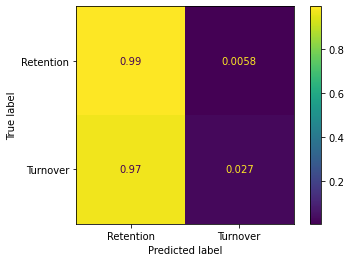

In [60]:
plot_confusion_matrix(lr_pipe, 
                      X_train_clean, 
                      y_train, 
                      normalize = 'true',
                      display_labels= ['Retention', 'Turnover']);

In a Logistic Regression model with default parameters, we can see that it has a really hard time classifying the minority class likely due to the class imbalance, so let's iterate this model to try to improve the recall scores.

In [61]:
lr_pipe1 = Pipeline(steps=[('ss', StandardScaler()),
                           ('lr', LogisticRegression(max_iter=1e4, 
                                                     class_weight='balanced',
                                                     random_state=42))
                          ])
lr_pipe1.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=10000.0,
                                    random_state=42))])

In [62]:
print_cv_scores(lr_pipe1, X_train_clean, y_train)

[0.64066442 0.62910008 0.64150547 0.63120269 0.62994113]
Training Accuracy 0.6344827586206897
##############
[0.60723297 0.61648444 0.61143818 0.60302775 0.62321278]
Cross_Val Accuracy 0.6122792262405382
##############
Training Recall: 0.6263344432112468
Cross_Val Recall: 0.5692507374631269


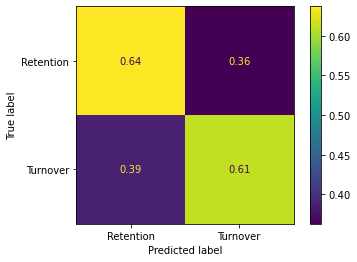

In [63]:
plot_confusion_matrix(lr_pipe1, 
                      X_train_clean, 
                      y_train, 
                      normalize = 'true',
                      display_labels= ['Retention', 'Turnover']);

By setting the `class_weight` hyperparameter to balanced, this helps for the logistic regression model to better classify the minority class and the recall score increases by over 50%.

Let's set up a grid search to find the best hyperparameters to maximize the recall score.

In [64]:
lr_grid_pipe = Pipeline(steps=[('ss', StandardScaler()),
                               ('lr', LogisticRegression(class_weight='balanced',
                                                         random_state=42))
                              ])

grid = {'lr__tol': [1e-5,1e-4,1e-3],
        'lr__C' : [1e-5,1e-3,1e-1, 1, 100],
        'lr__max_iter':[1e3, 1e5]}

In [65]:
gridsearch = GridSearchCV(lr_grid_pipe, 
                          grid, 
                          return_train_score=True, 
                          scoring='recall')

gridsearch.fit(X_train_clean, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             param_grid={'lr__C': [1e-05, 0.001, 0.1, 1, 100],
                         'lr__max_iter': [1000.0, 100000.0],
                         'lr__tol': [1e-05, 0.0001, 0.001]},
             return_train_score=True, scoring='recall')

In [66]:
gridsearch.best_params_

{'lr__C': 1e-05, 'lr__max_iter': 1000.0, 'lr__tol': 1e-05}

From these results, it seems that the logistic regression model likes higher regularization with the smallest C performing best, as well as the smallest tolerance. Let's run it again with different penalty types and some smaller C and tolerance levels.

In [67]:
lr_grid_pipe1 = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced',
                              max_iter = 1000,
                              solver = 'liblinear',
                              random_state=42))
])

grid1 = {'lr__tol': [1e-7, 1e-6, 1e-5],
        'lr__C' : [1e-7, 1e-6, 1e-5],
        'lr__penalty':['l1', 'l2']
        }

In [68]:
gridsearch1 = GridSearchCV(lr_grid_pipe1, 
                          grid1, 
                          return_train_score=True, 
                          scoring='recall')

gridsearch1.fit(X_train_clean, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'lr__C': [1e-07, 1e-06, 1e-05],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__tol': [1e-07, 1e-06, 1e-05]},
             return_train_score=True, scoring='recall')

In [69]:
gridsearch1.best_params_

{'lr__C': 1e-06, 'lr__penalty': 'l2', 'lr__tol': 1e-07}

Higher regularization strength and lower tolerance allows this logistic regression model to perform the best.

It looks like the l2 penalty continues to perform the best, let's just check to see the scores using different solvers.

In [70]:
lr_grid_pipe2 = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced',
                              max_iter = 1000,
                              C = 1e-06,
                              tol = 1e-07,
                              random_state=42))
])
grid2 = {'lr__solver': ['liblinear', 'lbfgs']}

In [71]:
gridsearch2 = GridSearchCV(lr_grid_pipe2, 
                          grid2, 
                          return_train_score=True, 
                          scoring='recall')

gridsearch2.fit(X_train_clean, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(C=1e-06,
                                                           class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           tol=1e-07))]),
             param_grid={'lr__solver': ['liblinear', 'lbfgs']},
             return_train_score=True, scoring='recall')

In [72]:
gridsearch2.best_params_

{'lr__solver': 'liblinear'}

In [73]:
gridsearch2.best_score_

0.6882831858407079

In [74]:
print_cv_scores(gridsearch2.best_estimator_, X_train_clean, y_train)

[0.55256518 0.55761144 0.55403701 0.55109336 0.55109336]
Training Accuracy 0.5532800672834315
##############
[0.54415475 0.54499579 0.56013457 0.52985702 0.56686291]
Cross_Val Accuracy 0.5492010092514719
##############
Training Recall: 0.696270070292268
Cross_Val Recall: 0.6882831858407079


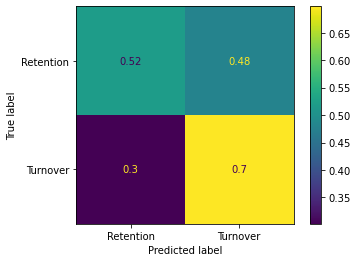

In [75]:
plot_confusion_matrix(gridsearch2.best_estimator_, 
                      X_train_clean, 
                      y_train, 
                      normalize='true',
                      display_labels= ['Retention', 'Turnover']);

In [76]:
gridsearch2.best_estimator_[-1].coef_

array([[ 1.50224504e-04,  9.47372677e-05, -1.30447766e-04,
         9.20521585e-06,  3.53112413e-05,  6.47635943e-05,
         2.96218314e-04,  9.28474762e-05, -1.62787208e-04,
        -5.15512556e-05, -3.90042172e-06, -1.12716287e-04,
        -7.87505672e-05, -1.85162930e-04, -7.44245071e-05,
        -4.16737680e-06, -2.05800198e-05, -2.68191957e-05,
         7.80819882e-05, -1.20070200e-05,  1.71526527e-05,
         1.30700279e-04,  2.33083525e-06,  5.66322094e-05,
        -3.68813654e-05, -4.91758099e-05,  3.34057079e-05,
         6.01789105e-05,  1.06310900e-04,  8.79038718e-05,
        -5.66107067e-05, -1.86474462e-05,  2.01116289e-05,
        -3.63619794e-05, -5.78521813e-05,  7.99496150e-05,
         6.90814142e-05,  2.02447915e-04, -1.45112886e-05,
         1.04833807e-04,  2.06757746e-04,  1.08767077e-04,
        -8.79265361e-05, -1.61316647e-05, -1.04021650e-04,
        -1.70747376e-04, -1.26278152e-04,  9.44296951e-05,
         1.69010453e-04, -2.75758928e-05, -3.88151547e-0

In [77]:
coef_dict = {}
for coef, feat in zip(abs(gridsearch2.best_estimator_[-1].coef_[0,:]),ohe_feature_names):
    coef_dict[feat] = coef

In [78]:
coef_dict

{'ohe__x0_TEACHER,SPEC EDUCATION': 0.00015022450440262486,
 'ohe__x1_ELEMENTARY SCHOOL': 9.473726768930658e-05,
 'ohe__x1_HIGH SCHOOL': 0.00013044776629104804,
 'ohe__x1_MIDDLE SCHOOL': 9.205215851449935e-06,
 'ohe__x2_M': 3.5311241344595006e-05,
 'ohe__x3_School Redesign Initiative': 6.47635942717114e-05,
 'ohe__x3_Turnaround': 0.00029621831411450226,
 'ohe__x4_Neighborhood': 9.284747620336685e-05,
 'ohe__x4_Special Admit': 0.000162787207821678,
 'ohe__x5_19104.0': 5.155125560540936e-05,
 'ohe__x5_19106.0': 3.9004217162958605e-06,
 'ohe__x5_19111.0': 0.00011271628702611264,
 'ohe__x5_19114.0': 7.875056722026416e-05,
 'ohe__x5_19115.0': 0.00018516292980751058,
 'ohe__x5_19116.0': 7.442450709289451e-05,
 'ohe__x5_19118.0': 4.167376803046257e-06,
 'ohe__x5_19119.0': 2.0580019846195233e-05,
 'ohe__x5_19120.0': 2.6819195696562076e-05,
 'ohe__x5_19121.0': 7.80819882498456e-05,
 'ohe__x5_19122.0': 1.200702000704895e-05,
 'ohe__x5_19123.0': 1.7152652657266594e-05,
 'ohe__x5_19124.0': 0.000130

In [79]:
max(coef_dict, key=coef_dict.get)

'Clim Score'

In [80]:
min(coef_dict, key=coef_dict.get)

'ohe__x5_19125.0'

The coefficients of the Logistic Regression that have the greatest magnitude are `Percent Black/African American` and `Clim Score` (school climate scores) which both represent school demographic factors.

__PCA with Logistic Regression__

The logistic regression is performing pretty well, but we want to see what happens if we reduce the features using Principal Component Analysis.

In [81]:
lr_PCA = Pipeline(steps=[('ss', StandardScaler()),
                         ('pca', PCA()),
                         ('lr', LogisticRegression(class_weight='balanced',
                                                   solver = 'liblinear',
                                                   C = 1e-06,
                                                   tol = 1e-07,
                                                   max_iter=1000,
                                                   random_state=42))
])

pca_grid = {'pca__n_components': [0.1, 0.2, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]}

In [82]:
pca_gridsearch = GridSearchCV(lr_PCA, 
                              pca_grid, 
                              return_train_score=True, 
                              scoring='recall')

pca_gridsearch.fit(X_train_clean, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA()),
                                       ('lr',
                                        LogisticRegression(C=1e-06,
                                                           class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear',
                                                           tol=1e-07))]),
             param_grid={'pca__n_components': [0.1, 0.2, 0.5, 0.7, 0.75, 0.8,
                                               0.85, 0.9, 0.95]},
             return_train_score=True, scoring='recall')

In [83]:
pca_gridsearch.best_params_

{'pca__n_components': 0.8}

In [84]:
pca_gridsearch.best_score_

0.6980609636184858

In [85]:
pca_gridsearch.best_estimator_[1].n_components_

39

The PCA that kept 80% of the variance of the model is the one that performs the best. Using Principal Component Analysis, the Logistic Regression model performed about 1% better on recall than without PCA. 

In an attempt to reduce false positives while still maintaining high recall, we explored using PolynomialFeatures.

In [86]:
lr_poly = Pipeline(steps=[('ss', StandardScaler()),
                          ('poly', PolynomialFeatures(degree =2)),
                          ('lr', LogisticRegression(class_weight='balanced',
                                                    solver = 'liblinear',
                                                    C = 1e-06,
                                                    tol = 1e-07,
                                                    max_iter=1000,
                                                    random_state=42))
])
lr_poly.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('poly', PolynomialFeatures()),
                ('lr',
                 LogisticRegression(C=1e-06, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='liblinear', tol=1e-07))])

In [87]:
print_cv_scores(lr_poly, X_train_clean, y_train)

[0.61143818 0.60218671 0.61480235 0.62888982 0.59608915]
Training Accuracy 0.6106812447434818
##############
[0.59629941 0.60134567 0.5862069  0.59125315 0.5862069 ]
Cross_Val Accuracy 0.5922624053826746
##############
Training Recall: 0.6378818596621038
Cross_Val Recall: 0.5745447394296953


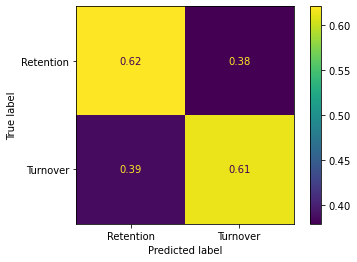

In [88]:
plot_confusion_matrix(lr_poly, 
                      X_train_clean, 
                      y_train, 
                      normalize='true',
                      display_labels= ['Retention', 'Turnover']);

Using Polynomial features does help to reduce the false positives of the model, however it reduces the cross validation recall score by 10% from without PolynomialFeatures, so we won't include it as part of the pipeline moving forward.

#### Best Logistic Regression with PCA

In [89]:
lr_PCA = Pipeline(steps=[('ss', StandardScaler()),
                         ('pca', PCA(n_components=0.8)),
                         ('lr', LogisticRegression(class_weight='balanced',
                                                   solver = 'liblinear',
                                                   C = 1e-07,
                                                   tol = 1e-07,
                                                   max_iter=1000,
                                                   random_state=42))
])

lr_PCA.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components=0.8)),
                ('lr',
                 LogisticRegression(C=1e-07, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='liblinear', tol=1e-07))])

In [90]:
print_cv_scores(lr_PCA, X_train_clean, y_train)

[0.54857023 0.55529857 0.55067283 0.54730866 0.54667788]
Training Accuracy 0.5497056349873843
##############
[0.54079058 0.54667788 0.55845248 0.53322119 0.55929352]
Cross_Val Accuracy 0.5476871320437342
##############
Training Recall: 0.6991559995067209
Cross_Val Recall: 0.6962871189773845


In [91]:
lr_acc = 0.5476871320437342 * 100
lr_rec = 0.6962871189773845 * 100

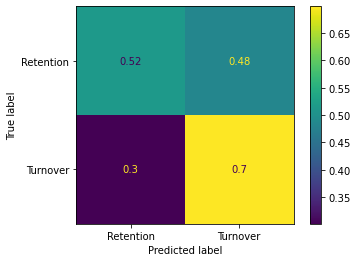

In [92]:
plot_confusion_matrix(lr_PCA, 
                      X_train_clean, 
                      y_train, 
                      normalize='true',
                      display_labels= ['Retention', 'Turnover']);

Let's look at the features playing a role in the Logistic Regression after they have gone through PCA.

In [93]:
lr_PCA[1].explained_variance_ratio_

array([0.11405829, 0.05828288, 0.04870678, 0.03241171, 0.02890407,
       0.02510801, 0.02332368, 0.02232165, 0.01987881, 0.01952622,
       0.01858635, 0.01705375, 0.01636431, 0.01575433, 0.01564298,
       0.01545155, 0.01519688, 0.01479706, 0.01457451, 0.01431715,
       0.01395437, 0.01395201, 0.01374047, 0.013551  , 0.01352098,
       0.01349132, 0.01343007, 0.01336903, 0.01332781, 0.01332001,
       0.01331564, 0.01329995, 0.01327519, 0.01326033, 0.01324003,
       0.01321464, 0.01320674, 0.01317944, 0.01316477])

In [94]:
sum(lr_PCA[1].explained_variance_ratio_[:2])

0.17234117136927213

In [95]:
importance_df=create_importance_dataframe(lr_PCA[1])
display(importance_df.head())

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39
"ohe__x0_TEACHER,SPEC EDUCATION",0.029606,0.001615,0.000503,0.017213,0.143520,0.002570,0.005794,0.122205,0.061482,0.032753,0.064837,0.080803,0.084890,0.129495,0.028429,0.026883,0.147452,0.000618,0.384019,0.103190,0.112015,0.185193,0.073021,0.093457,0.063219,0.047263,0.047897,0.003522,0.066134,0.086494,0.023853,0.014110,0.000239,0.033176,0.019649,0.007527,0.026249,0.041651,0.036283
ohe__x1_ELEMENTARY SCHOOL,0.004865,0.362659,0.163322,0.211459,0.083530,0.120961,0.018410,0.087504,0.120130,0.091444,0.015531,0.077502,0.067782,0.058050,0.063550,0.032168,0.058033,0.057501,0.021345,0.025367,0.026966,0.002334,0.005484,0.001738,0.016059,0.010268,0.020351,0.006803,0.010933,0.007659,0.001067,0.001947,0.007139,0.000667,0.002076,0.023845,0.007887,0.001172,0.014728
ohe__x1_HIGH SCHOOL,0.004687,0.363214,0.122668,0.171493,0.027888,0.115611,0.130560,0.005111,0.169761,0.010935,0.049372,0.106322,0.098642,0.022508,0.017645,0.064142,0.053316,0.011035,0.014226,0.034161,0.021082,0.011331,0.082066,0.022863,0.020409,0.014114,0.050691,0.008996,0.006903,0.003343,0.008236,0.023552,0.004799,0.001394,0.005997,0.006743,0.007526,0.000067,0.000477
ohe__x1_MIDDLE SCHOOL,0.012827,0.017275,0.093393,0.002824,0.073193,0.057934,0.178130,0.205138,0.490578,0.155410,0.134872,0.106956,0.204350,0.114188,0.054086,0.137425,0.149983,0.019480,0.002841,0.000648,0.061674,0.015850,0.009721,0.008053,0.014720,0.004983,0.006043,0.017034,0.008461,0.000745,0.005292,0.010736,0.006470,0.011719,0.015149,0.009600,0.002702,0.001089,0.003537
ohe__x2_M,0.000935,0.150581,0.053592,0.101927,0.000604,0.074113,0.014739,0.040349,0.000620,0.013176,0.018337,0.015968,0.015125,0.100241,0.146625,0.017653,0.094804,0.019422,0.303796,0.091045,0.130197,0.027303,0.067525,0.064880,0.065492,0.072130,0.075919,0.070154,0.019480,0.020662,0.000135,0.024299,0.009403,0.010517,0.005311,0.045481,0.025352,0.004084,0.027194


In [96]:
pc1_top_10_features = importance_df['PC1'].sort_values(ascending = False)[:10]
print(), print(f'PC1 top 10 features are')
display(pc1_top_10_features)


PC1 top 10 features are


Clim Score                         0.306016
Overall Score                      0.303483
Attendance (95%+) Score            0.296413
Ach Score                          0.293234
Retention Score                    0.283305
OSS Score                          0.246988
Economically Disadvantaged Rate    0.226529
Percent Asian                      0.213329
Percent IEP                        0.208463
Percent White                      0.197804
Name: PC1, dtype: float64

In [97]:
pc2_top_10_features = importance_df['PC2'].sort_values(ascending = False)[:10]
print(), print(f'PC2 top 10 features are')
display(pc2_top_10_features)


PC2 top 10 features are


ohe__x1_HIGH SCHOOL                  0.363214
ohe__x1_ELEMENTARY SCHOOL            0.362659
ohe__x4_Neighborhood                 0.331776
ohe__x4_Special Admit                0.319043
Student Survey Teaching Score        0.259795
Percent ELL                          0.207612
Percent Multi-Race                   0.203060
Percent Hispanic                     0.197211
Parent Survey Participation Score    0.184248
Percent Black/African American       0.180343
Name: PC2, dtype: float64

The Climate Score and the School Level are the features that contribute the most to PC1 and PC2 which explain 17% of the variance. 

#### K-Neighbors Classification

In [98]:
knn_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
knn_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('knn', KNeighborsClassifier())])

In [99]:
print_cv_scores(knn_pipe, X_train_clean, y_train)

[0.82884777 0.83410429 0.83746846 0.83368377 0.82926829]
Training Accuracy 0.8326745164003364
##############
[0.78805719 0.78973928 0.78469302 0.78216989 0.79310345]
Cross_Val Accuracy 0.7875525651808243
##############
Training Recall: 0.23956098162535455
Cross_Val Recall: 0.10656440511307767


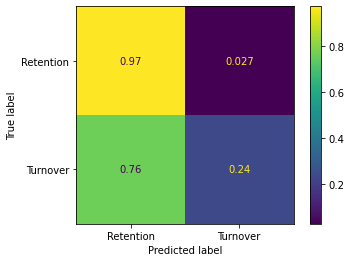

In [100]:
plot_confusion_matrix(knn_pipe, 
                      X_train_clean, 
                      y_train, 
                      normalize='true',
                      display_labels= ['Retention', 'Turnover']);

The k-nearest neighbors classifier is doing well to predict retention, but struggles to identify teachers who are leaving, which is the main focus of this project. Let's see if we can improve the performance of the model by trying out different hyperparameters like the number of neighbors and the distance metric.

In [101]:
# knn_pipe = Pipeline(steps=[
#     ('ss', StandardScaler()),
#     ('knn', KNeighborsClassifier())
# ])

# knn_grid = {'knn__n_neighbors': [3, 5, 7],
#             'knn__p': [1, 2, 3]}

# knn_gridsearch = GridSearchCV(knn_pipe, 
#                               knn_grid, 
#                               return_train_score=True, 
#                               scoring='recall')

# knn_gridsearch.fit(X_train_clean, y_train)

In [102]:
# knn_gridsearch.best_params_

The grid search performed above has been commented out to save runtime when rerunning this notebook, however, the best parameters are used in the below knn pipeline.

Here we implemented SMOTE to try to mitigate the class imbalance.

In [103]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe

knn_pipe_best = imbpipe(steps=[('ss', StandardScaler()),
                               ('sm', SMOTE()),
                               ('knn', KNeighborsClassifier(n_neighbors=3, p=2))
])

knn_pipe_best.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('sm', SMOTE()),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

In [104]:
print_cv_scores(knn_pipe_best, X_train_clean, y_train)

[0.84714045 0.85050463 0.8559714  0.85050463 0.84650967]
Training Accuracy 0.8501261564339782
##############
[0.6804037  0.69974769 0.67788057 0.68124474 0.6980656 ]
Cross_Val Accuracy 0.6874684608915055
##############
Training Recall: 0.712923911703046
Cross_Val Recall: 0.32679252704031464


In [105]:
knn_acc = 0.68242220353238 * 100
knn_rec = 0.3285545722713864 * 100

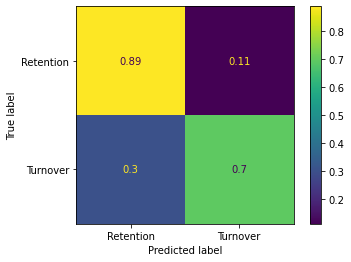

In [106]:
plot_confusion_matrix(knn_pipe_best, 
                      X_train_clean, 
                      y_train, 
                      normalize='true',
                      display_labels= ['Retention', 'Turnover']);

Based on the performance of the K-Nearest Neighbors Classifier, with only 33% recall, I don't think it's wise to explore this classifier any further.

#### Decision Tree

In [107]:
dtc_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('pca', PCA(n_components=0.8)),
    ('dtc', DecisionTreeClassifier(class_weight='balanced'))
])
dtc_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components=0.8)),
                ('dtc', DecisionTreeClassifier(class_weight='balanced'))])

In [108]:
dtc_pipe[-1].get_depth()

43

In [109]:
print_cv_scores(dtc_pipe, X_train_clean, y_train)

[0.90117746 0.90117746 0.90306981 0.90517241 0.90412111]
Training Accuracy 0.9029436501261564
##############
[0.66694701 0.67199327 0.67535744 0.6568545  0.67283431]
Cross_Val Accuracy 0.6687973086627418
##############
Training Recall: 0.9777972623011468
Cross_Val Recall: 0.303716814159292


With default hyperparameters, it's clear that the decision tree is overfitting. Let's prune the tree using GridSearchCV

In [110]:
dtc_pipe = Pipeline(steps=[('ss', StandardScaler()),
                           ('pca', PCA()),
                           ('dtc', DecisionTreeClassifier(class_weight='balanced', 
                                                          random_state=42))
])

In [111]:
dtc_grid = {'dtc__max_depth': [5, 6, 7],
            'dtc__min_samples_leaf': [1, 2, 3],
            'pca__n_components': [0.75, 0.8, 0.85, 0.9],
            'dtc__max_features': ['auto', 'sqrt', 'log2']}

In [112]:
dtc_gridsearch = GridSearchCV(dtc_pipe, 
                              dtc_grid, 
                              scoring='recall')

dtc_gridsearch.fit(X_train_clean, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA()),
                                       ('dtc',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid={'dtc__max_depth': [5, 6, 7],
                         'dtc__max_features': ['auto', 'sqrt', 'log2'],
                         'dtc__min_samples_leaf': [1, 2, 3],
                         'pca__n_components': [0.75, 0.8, 0.85, 0.9]},
             scoring='recall')

In [113]:
dtc_gridsearch.best_params_

{'dtc__max_depth': 5,
 'dtc__max_features': 'log2',
 'dtc__min_samples_leaf': 2,
 'pca__n_components': 0.8}

In [114]:
print_cv_scores(dtc_gridsearch.best_estimator_, X_train_clean, y_train)

[0.504836   0.58326325 0.66042893 0.51198486 0.48780488]
Training Accuracy 0.549663582842725
##############
[0.45584525 0.55929352 0.63414634 0.48864592 0.48107653]
Cross_Val Accuracy 0.5238015138772077
##############
Training Recall: 0.7262658774201505
Cross_Val Recall: 0.6508790560471975


In [115]:
dtc_acc = 0.5238015138772077 * 100
dtc_rec = 0.6508790560471975 * 100

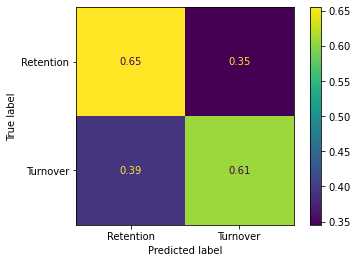

In [116]:
dtc_gridsearch.best_estimator_.fit(X_train_clean, y_train)
plot_confusion_matrix(dtc_gridsearch.best_estimator_, 
                      X_train_clean, 
                      y_train,
                      normalize = 'true',
                      display_labels= ['Retention', 'Turnover']);

In [117]:
dtc_gridsearch.best_estimator_[-1].feature_importances_

array([ 2.60078312e-01,  9.73720484e-02,  1.55234682e-01,  3.94634299e-02,
        9.58669002e-02,  2.07937856e-02,  5.32360037e-03,  5.08775254e-02,
        2.18712825e-02,  7.82476855e-04,  0.00000000e+00,  0.00000000e+00,
        1.48990853e-02,  1.03300859e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.42256028e-02,  0.00000000e+00,  3.09868525e-02,
        6.18151551e-02,  7.25946673e-02,  0.00000000e+00,  0.00000000e+00,
        1.95701742e-02,  0.00000000e+00,  2.74723335e-03,  0.00000000e+00,
        1.72103021e-02,  0.00000000e+00,  0.00000000e+00,  7.95679837e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.46008545e-18,  0.00000000e+00,  0.00000000e+00])

In [118]:
dtc_gridsearch.best_estimator_[-1].n_features_in_

39

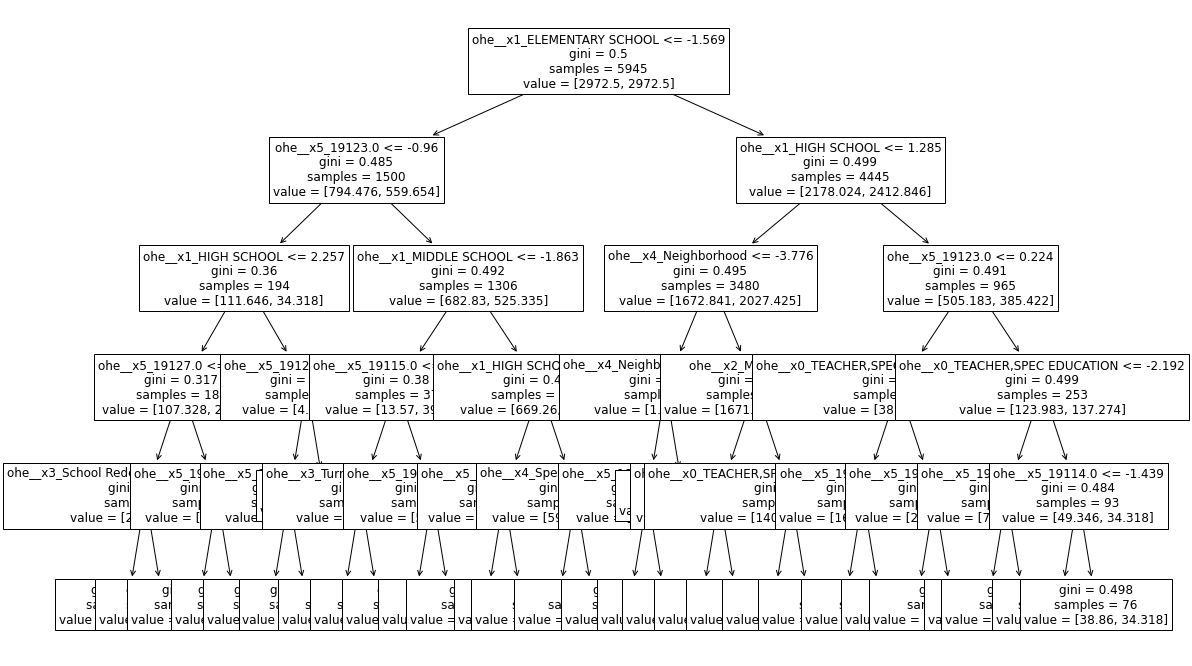

In [119]:
plt.figure(figsize=(18,12)) 
plot_tree(dtc_gridsearch.best_estimator_[-1], 
          feature_names=ohe_feature_names, 
          fontsize=12)
plt.show()

Pruning has helped to make the decision tree model less overfit and perform better on the recall during cross validation, however it still isn't as high as the recall for Logistic Regression. Let's try a random forest model to see if scores will imporve further.

#### Random Forest

In [120]:
rf_pipe = Pipeline(steps=[('ss', StandardScaler()),
                          ('pca', PCA()),
                          ('rf', RandomForestClassifier())])
rf_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA()),
                ('rf', RandomForestClassifier())])

In [121]:
print_cv_scores(rf_pipe, X_train_clean, y_train)

[0.936291   0.93608074 0.93881413 0.93776283 0.93860387]
Training Accuracy 0.9375105130361648
##############
[0.75021026 0.76030278 0.74179983 0.75189235 0.74936922]
Cross_Val Accuracy 0.7507148864592094
##############
Training Recall: 0.7262439265014182
Cross_Val Recall: 0.18030285152409048


In [122]:
rf_pipe = Pipeline(steps=[('ss', StandardScaler()),
                          ('pca', PCA()),
                          ('rf', RandomForestClassifier(class_weight='balanced',
                                                        n_jobs = -1,
                                                        random_state=42))])

rf_grid = {'rf__n_estimators': [50, 100],
           'rf__max_depth': [5, 10, 15],
           'rf__min_samples_leaf': [1, 2],
           'rf__max_features': ['sqrt', 'log2'],
           'pca__n_components': [0.75, 0.8, 0.9]}

In [123]:
rf_gridsearch = GridSearchCV(rf_pipe, 
                             rf_grid, 
                             scoring='recall')

rf_gridsearch.fit(X_train_clean, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA()),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'pca__n_components': [0.75, 0.8, 0.9],
                         'rf__max_depth': [5, 10, 15],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__n_estimators': [50, 100]},
             scoring='recall')

In [124]:
rf_gridsearch.best_params_

{'pca__n_components': 0.9,
 'rf__max_depth': 5,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 1,
 'rf__n_estimators': 50}

In [125]:
rf_gridsearch.best_score_

0.5132940019665683

In [126]:
print_cv_scores(rf_gridsearch.best_estimator_, X_train_clean, y_train)

[0.70836838 0.70374264 0.7195122  0.70584525 0.68902439]
Training Accuracy 0.7052985702270816
##############
[0.6568545  0.66021867 0.64003364 0.63835156 0.66190076]
Cross_Val Accuracy 0.6514718250630782
##############
Training Recall: 0.6625238623751387
Cross_Val Recall: 0.5132940019665683


In [127]:
rf_acc = 0.6514718250630782 * 100
rf_rec = 0.5132940019665683 * 100

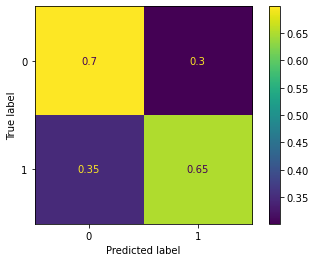

In [128]:
rf_gridsearch.best_estimator_.fit(X_train_clean, y_train)
plot_confusion_matrix(rf_gridsearch.best_estimator_, 
                      X_train_clean, 
                      y_train,
                      normalize = 'true');

By generating a random forest with many trees, it is resuting in worse performance on the recall. It seems as though the class imbalance may be impacting it still as it is ding a better job predicting retention than it is predicting turnover.

#### XGBoost

In [129]:
xgb_pipe = Pipeline(steps=[('ss', StandardScaler()),
                           ('pca', PCA(n_components=0.9)),
                           ('xgb', XGBClassifier(objective ='binary:logistic', 
                                                 colsample_bytree = 0.2, 
                                                 learning_rate = 0.3,
                                                 max_depth = 6, 
                                                 alpha = 10, 
                                                 n_estimators = 1000))])
xgb_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('xgb',
                 XGBClassifier(alpha=10, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.2, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=1000,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [130]:
print_cv_scores(xgb_pipe, X_train_clean, y_train)

[0.83767872 0.83557611 0.84125315 0.83809924 0.83788898]
Training Accuracy 0.8380992430613962
##############
[0.79730866 0.80151388 0.78973928 0.80656013 0.80740118]
Cross_Val Accuracy 0.8005046257359126
##############
Training Recall: 0.18228092243186583
Cross_Val Recall: 0.0648220255653884


In [131]:
xgb_pipe_smote = imbpipe(steps=[('ss', StandardScaler()),
                                ('sm', SMOTE(random_state=42)),
                                ('xgb', XGBClassifier(objective ='binary:logistic', 
                                                      colsample_bytree = 0.3, 
                                                      learning_rate = 0.1,
                                                      max_depth = 6, 
                                                      alpha = 10, 
                                                      n_estimators = 50))])
xgb_pipe_smote.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('sm', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(alpha=10, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.3, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [132]:
print_cv_scores(xgb_pipe_smote, X_train_clean, y_train)

[0.79100084 0.7901598  0.79478553 0.78553406 0.78826745]
Training Accuracy 0.7899495374264088
##############
[0.74011775 0.75946173 0.745164   0.73675357 0.77207738]
Cross_Val Accuracy 0.7507148864592094
##############
Training Recall: 0.3694453076828216
Cross_Val Recall: 0.26287905604719763


In [133]:
xgb_acc = 0.7507148864592094 * 100
xgb_rec = 0.26287905604719763 * 100

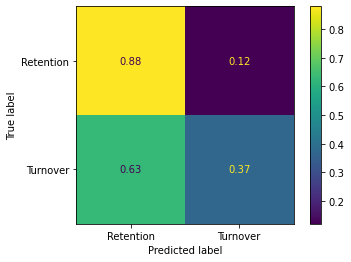

In [134]:
plot_confusion_matrix(xgb_pipe_smote, X_train_clean, y_train, normalize='true',
                      display_labels=['Retention', 'Turnover']);

The XGBoost is not doing well predicting turnover. Even with SMOTE it is not able to predict the class of interest well at all.

__Identifying Best Performing Model__

In [135]:
X_labels = ['Dummy''\n''Classification',
            'XGBoost',
            'KNN',
            'Random''\n''Forest',
            'Linear''\n''SVC',
            'Decision''\n''Tree',
            'Logistic''\n''Regression']

y1 = [dc_acc, xgb_acc, knn_acc, rf_acc, svc_acc, dtc_acc, lr_acc]
y2 = [dc_rec, xgb_rec, knn_rec, rf_rec, svc_rec, dtc_rec, lr_rec]

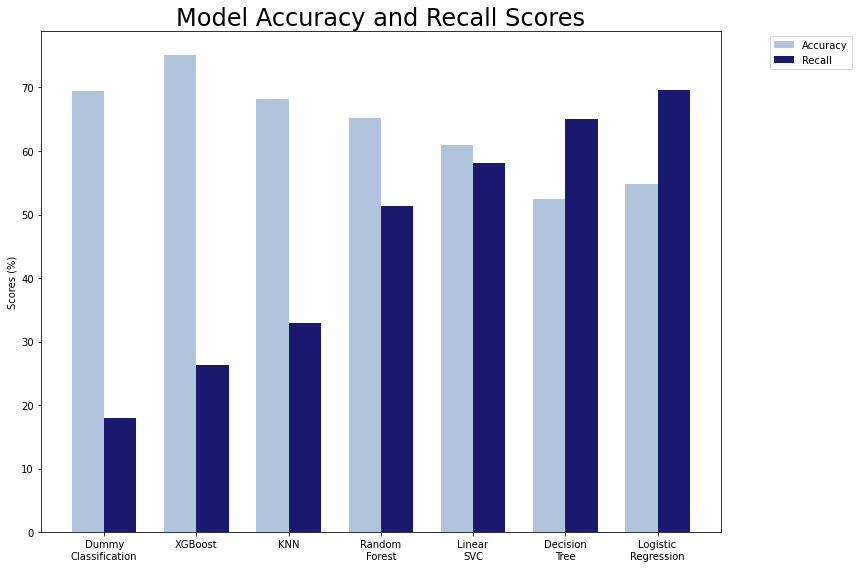

In [136]:
width = 0.35  # the width of the bars
x = np.arange(len(X_labels))
fig, ax = plt.subplots(figsize=(12,8))

rects1 = ax.bar(x - width/2, y1, width, label='Accuracy', color='lightsteelblue')
rects2 = ax.bar(x + width/2, y2, width, label='Recall', color='midnightblue')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores (%)')
ax.set_title('Model Accuracy and Recall Scores', fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(X_labels)
ax.legend(bbox_to_anchor=(1.2, 1))

fig.tight_layout()
#set background color to white
fig.patch.set_facecolor('white')
plt.show()
#save the figure in the images folder
fig.savefig('images/Model_Scores.png')

The best model is Logistic Regression. This model had the highest recall score compared to all the other models.

### Evaluation

Let's evaluate the best model using the holdout test set. First we will run the test set through the cleaning pipeline and then predict the outcomes on the test set.

In [137]:
best_model = Pipeline(steps=[('ss', StandardScaler()),
                             ('pca', PCA(n_components=0.8)),
                             ('lr', LogisticRegression(class_weight='balanced',
                                                       solver = 'liblinear',
                                                       C = 1e-07,
                                                       tol = 1e-07,
                                                       max_iter=1000,
                                                       random_state=42))])

best_model.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components=0.8)),
                ('lr',
                 LogisticRegression(C=1e-07, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='liblinear', tol=1e-07))])

In [138]:
X_test_clean = cleaning_pipeline.transform(X_test)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/meaghanross/Documents/Flatiron/Capstone/Predicting_Teacher_Turnover/src.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('float64')
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [139]:
y_pred = best_model.predict(X_test_clean)


In [140]:
best_model.score(X_test_clean, y_test)

0.5227043390514632

In [141]:
recall_score(y_test, y_pred)

0.6346666666666667

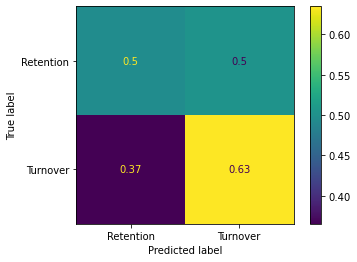

In [142]:
plot_confusion_matrix(best_model, 
                      X_test_clean, 
                      y_test, 
                      normalize='true',
                      display_labels=['Retention', 'Turnover'])
fig.savefig('images/Final_Matrix.png');

On the holdout test set, the Logisitic Regression model performs at 63% for the recall score. The model does a good job of reducing those false negative where retention was predicted, but the teacher actually left their school. It's clear that the model is struggling to make correct predictions for teachers that were retained in their school with a lot of false positives, however, false positives in this context are not as negatively impactful to schools and the costs associated with high teacher turnover rates.

## Conclusion

The recall score (63%) of the best model, Logistic Regression with PCA, is lower than ideal. However, being able to predict teacher turnover and plan ahead for intervention to retain teachers within the school district is better than high rates of teacher turnover that are costly with no information as to why.

To improve the predictive power of the model, I recommend the following for next steps:

* Obtain additional occupational factors including certification pathway, subject taught, and evaluation scores.
* Include records across multiple school years.

Additionally, in the future, I'd like to explore the generalizability of this model to be able to use in other large urban school districts such as New York City.